In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import argparse
import glob

## Timing Distribution of Segments and Hits

In [3]:
# Select segments that produced hits and record their start time, interaction type, parent interaction type, pdg_id

hitsamount = 0
neutronamount = 0

seg_whits_t = []
hit_t = []
n_prod_t = []

traj_whits_startprocess = []
traj_whits_startsubprocess = []
traj_whits_endprocess = []
traj_whits_endsubprocess = []
traj_whits_pdg = []

parent_whits_startprocess = []
parent_whits_startsubprocess = []
parent_whits_endprocess = []
parent_whits_endsubprocess = []
parent_whits_pdg = []

seg_whits_pdg = []
seg_whits_dE = []

for file in glob.iglob('/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/DTG_prod_v3/FLOW/*.hdf5'):
#for file in glob.iglob('/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/AmBe_Prod_V4/FLOW/*.hdf5'):
#for file in glob.iglob('/global/cfs/cdirs/dune/users/lmlepin/2x2_neutron_prod/AmBe_Prod_V4/FLOW/2x2_MyQGSP_BERT_ArHP_AmBe_AmBe_Prod_V4_0.FLOW.hdf5'):
    with h5py.File(file, 'r') as f:
        hitsamount += len(f['charge/calib_prompt_hits/data'])
        neutronamount += max(f['mc_truth/trajectories/data']['vertex_id'])
        # Collect the arrival time of the hits
        hit_t.extend((f['charge/calib_prompt_hits/data']['ts_pps']%2e6)*0.1)

        # Collect segments that generated hits
        '''
        seg_whits = []
        bt_frac = f['mc_truth/calib_prompt_hit_backtrack/data']['fraction']
        bt_seg_ids = f['mc_truth/calib_prompt_hit_backtrack/data']['segment_ids']
        for i in range(len(bt_frac)):
            for j in range(len(bt_frac[i])):
                if abs(bt_frac[i][j]) > 0.0001 and bt_seg_ids[i][j] != -1:
                    seg_whits.append(bt_seg_ids[i][j])
        # Build a cache of trajectories that generated hits
        seg_whits_raw = []
        for i in list(set(seg_whits)):
            seg_whits_raw.append(f['mc_truth/segments/data'][f['mc_truth/segments/data']['segment_id']==i])
        '''
        # IMPORTANT: For now inspect all segments instead of only segments that produced hits
        seg_whits_raw = f['mc_truth/segments/data']

        #n_vertexid_temp = []
        # Temporarily store some identifying info for the trajectories with segments that generated hits
        traj_whits_trajid = []   # Not unique in a file
        traj_whits_vertid = []
        
        # Filter out neutral segments (they should not be producing charge in the detector, this was a larndsim issue)
        for i in seg_whits_raw:
            if i['pdg_id']!=2112 and i['pdg_id']!=22:
                # Record the particle type that generated hits
                #seg_whits_pdg.append(i['pdg_id'][0])
                seg_whits_pdg.append(i['pdg_id'])

                # Record the corresponding trajectories
                traj_whits_trajid.append(i['traj_id'])
                traj_whits_vertid.append(i['vertex_id'])

                # Get the segment start time
                #tstart_temp = i['t0_start'][0] - (i['event_id'][0]%1000)*1.2*10**6
                #tstart_temp = i['t_start'][0]
                tstart_temp = i['t_start']
                seg_whits_t.append(tstart_temp)

                # Get total deposited energy per segment
                #seg_whits_dE.append(i['dE'][0])
                seg_whits_dE.append(i['dE'])

        # Backtrack all the trajectories and identify the interaction processes that produced those segments
        for i in range(len(traj_whits_trajid)):
            samevert_trajs = f['mc_truth/trajectories/data'][f['mc_truth/trajectories/data']['vertex_id']==traj_whits_vertid[i]]
            traj = samevert_trajs[samevert_trajs['traj_id']==traj_whits_trajid[i]]

            # Record the interaction processes for the trajectories
            traj_whits_startprocess.append(traj['start_process'][0])
            traj_whits_startsubprocess.append(traj['start_subprocess'][0])
            traj_whits_endprocess.append(traj['end_process'][0])
            traj_whits_endsubprocess.append(traj['end_subprocess'][0])
            traj_whits_pdg.append(traj['pdg_id'][0])

            # Record the interaction processes of the trajectories' parents
            parent_traj = samevert_trajs[samevert_trajs['traj_id']==traj['parent_id']]
            parent_whits_startprocess.append(parent_traj['start_process'][0])
            parent_whits_startsubprocess.append(parent_traj['start_subprocess'][0])
            parent_whits_endprocess.append(parent_traj['end_process'][0])
            parent_whits_endsubprocess.append(parent_traj['end_subprocess'][0])
            parent_whits_pdg.append(parent_traj['pdg_id'][0])
        break # Only checking one file for now

In [4]:
# First check the distribution of types of processes

parent_whits_process = [f"{parent_whits_startprocess[i]}:{parent_whits_startsubprocess[i]}-{parent_whits_endprocess[i]}:{parent_whits_endsubprocess[i]}-{parent_whits_pdg[i]}-{seg_whits_pdg[i]}" for i in range(len(parent_whits_startprocess))]

traj_whits_process = [f"{traj_whits_startprocess[i]}:{traj_whits_startsubprocess[i]}-{traj_whits_endprocess[i]}:{traj_whits_endsubprocess[i]}-{traj_whits_pdg[i]}-{seg_whits_pdg[i]}" for i in range(len(traj_whits_startprocess))]

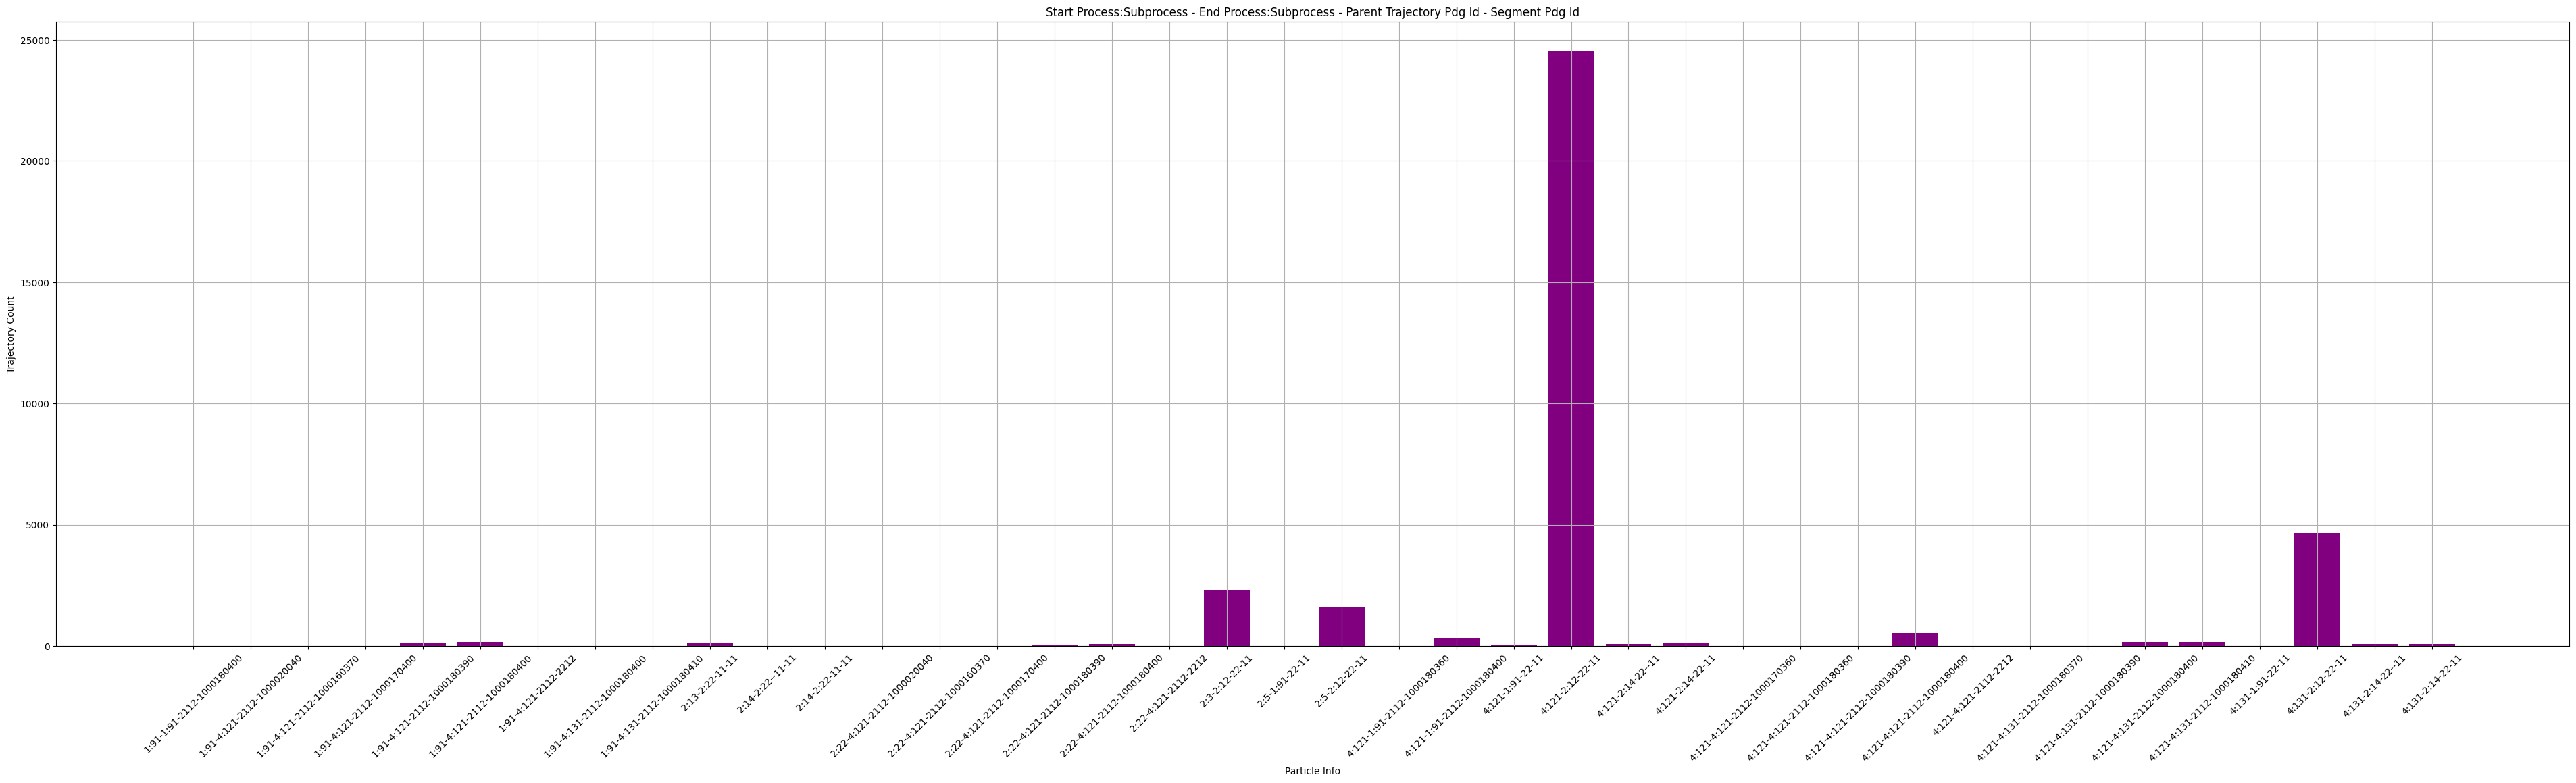

In [5]:
# Plot the count of parent trajectory processes

plt.figure(figsize=(48, 12))

labels, counts = np.unique(parent_whits_process, return_counts=True)

plt.bar(labels, counts, color='purple', align='center')
plt.gca().set_xticks(labels)
#plt.yscale('log')
plt.xlabel('Particle Info')
plt.ylabel('Trajectory Count')
plt.title(r'Start Process:Subprocess - End Process:Subprocess - Parent Trajectory Pdg Id - Segment Pdg Id')
plt.grid(True)
#plt.xlim((-50*(1.2e9),50*(1.2e9)))
plt.xticks(rotation=45)
plt.show()

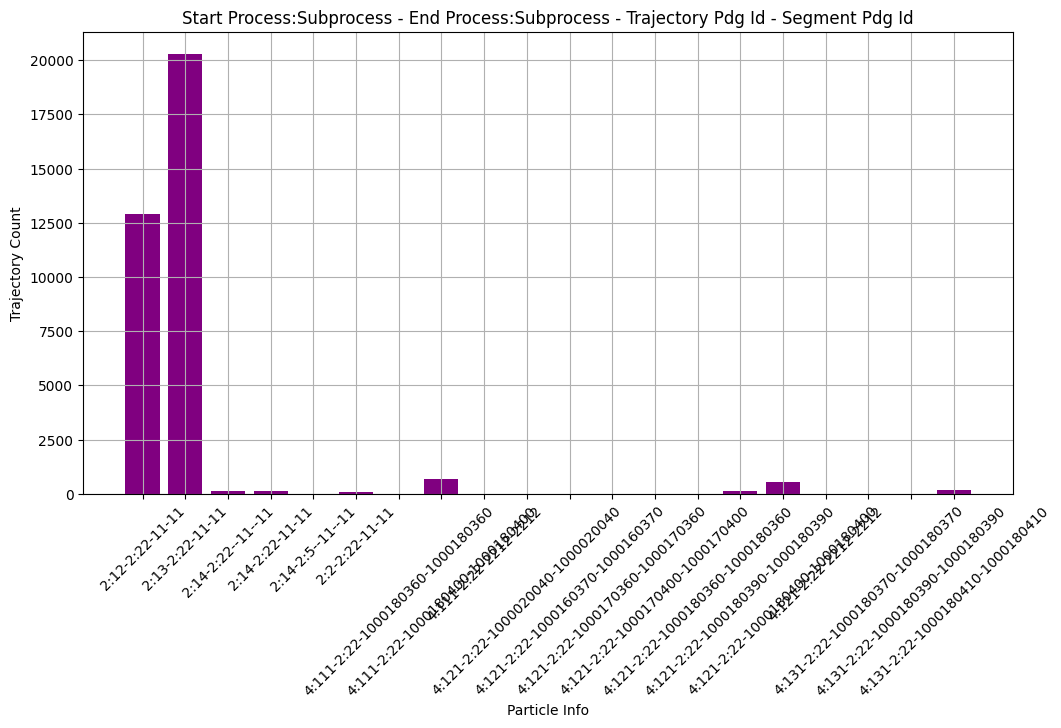

In [6]:
# Plot the count of trajectory processes

plt.figure(figsize=(12, 6))

labels, counts = np.unique(traj_whits_process, return_counts=True)

plt.bar(labels, counts, color='purple', align='center')
plt.gca().set_xticks(labels)
#plt.yscale('log')
plt.xlabel('Particle Info')
plt.ylabel('Trajectory Count')
plt.title(r'Start Process:Subprocess - End Process:Subprocess - Trajectory Pdg Id - Segment Pdg Id')
plt.grid(True)
#plt.xlim((-50*(1.2e9),50*(1.2e9)))
plt.xticks(rotation=45)
plt.show()

In [7]:
# Plot the start time distribution but categorized by different interaction types

# Amount of each interaction
NeutronCapture_amount = 0
InelasticScatter_amount = 0
InelasticScatterProton_amount = 0
other_amount = 0  # the electrons that produced hits are associated with a nucleus rather than a gamma or sth else, 
                          # and this bin also contains gammas that scattered more than once and could not be backtracked fully.
                          # name this "other" for now

# Segment start times of each types of interaction
NeutronCapture_tstart = []
InelasticScatter_tstart = []
InelasticScatterProton_tstart = []
other_tstart = []

# Place segment start times into categories
# NOTE: inlude the "move" process (1:91) in the interaction that it originally belongs to
for i in range(len(seg_whits_t)):
    # IMPORTANT: Lumping the compton scattered photons with the pair produced photons together for now
    if (parent_whits_process[i] == "4:131-2:12-22-11") or (parent_whits_process[i] == "4:131-1:91-22-11") or (parent_whits_process[i] == "4:131-2:14-22-11") or (parent_whits_process[i] == "4:131-2:14-22--11"):
        NeutronCapture_amount += 1
        NeutronCapture_tstart.append(seg_whits_t[i])
    elif (parent_whits_process[i] == "4:121-2:12-22-11") or (parent_whits_process[i] == "4:121-1:91-22-11") or (parent_whits_process[i] == "4:121-2:14-22-11") or (parent_whits_process[i] == "4:121-2:14-22--11"):
        InelasticScatter_amount += 1
        InelasticScatter_tstart.append(seg_whits_t[i])
    elif (parent_whits_process[i] == "4:121-4:121-2112-2212") or (parent_whits_process[i] == "1:91-4:121-2112-2212"):
        InelasticScatterProton_amount += 1
        InelasticScatterProton_tstart.append(seg_whits_t[i])
    else:
        other_amount += 1
        other_tstart.append(seg_whits_t[i])

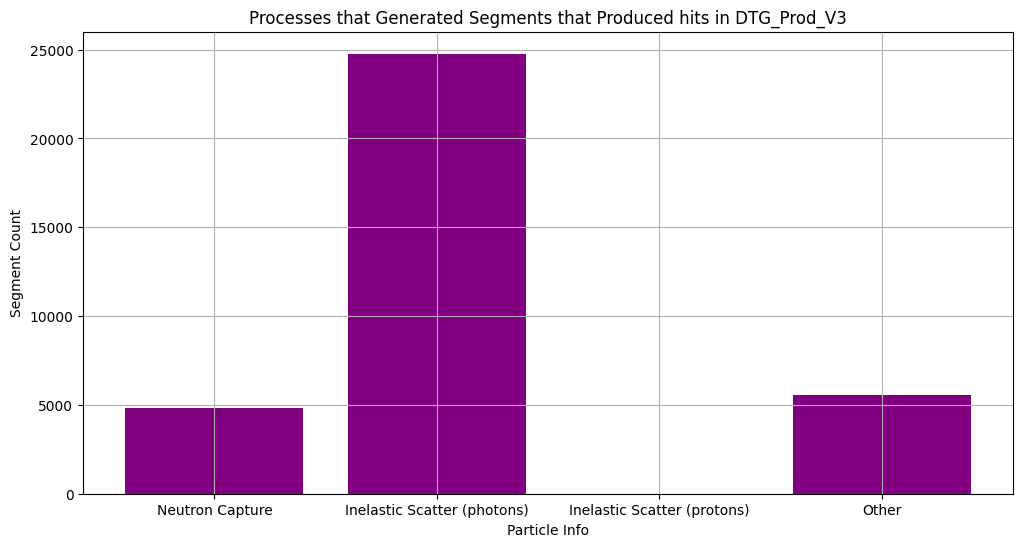

In [8]:
# Plot bar plot of different categories of processes

plt.figure(figsize=(12, 6))

process_labels = ["Neutron Capture", "Inelastic Scatter (photons)", "Inelastic Scatter (protons)", "Other"]
process_counts = [NeutronCapture_amount, InelasticScatter_amount, InelasticScatterProton_amount, other_amount]

plt.bar(process_labels, process_counts, color='purple', align='center')
plt.gca().set_xticks(process_labels)
#plt.yscale('log')
plt.xlabel('Particle Info')
plt.ylabel('Segment Count')
plt.title(r'Processes that Generated Segments that Produced hits in DTG_Prod_V3')
plt.grid(True)
#plt.xlim((-50*(1.2e9),50*(1.2e9)))
#plt.xticks(rotation=45)
plt.show()

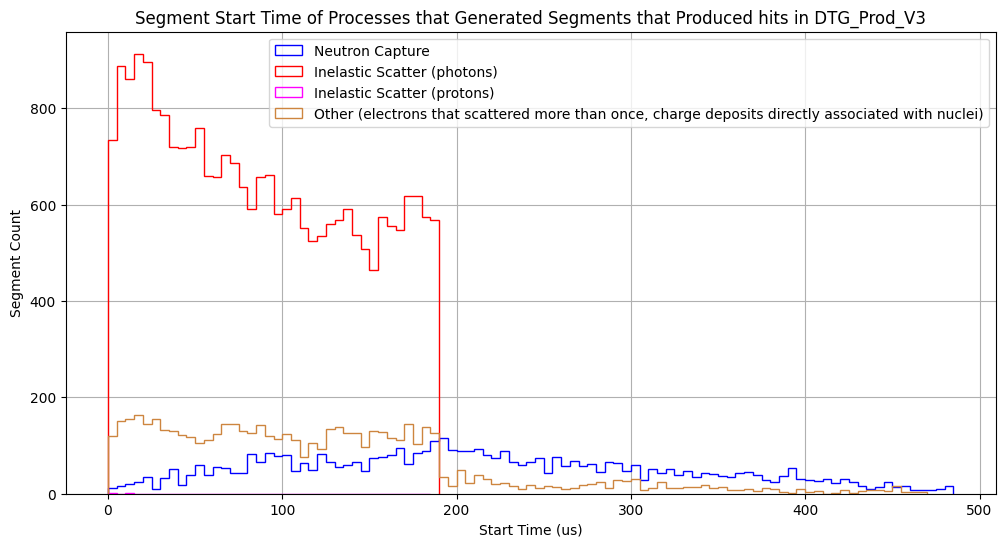

In [9]:
# Plot the arrival time of each types of segments

plt.figure(figsize=(12, 6))

plt.hist(NeutronCapture_tstart, bins=np.arange(0, max(NeutronCapture_tstart), 5), histtype='step', color='blue', label='Neutron Capture')
plt.hist(InelasticScatter_tstart, bins=np.arange(0, max(InelasticScatter_tstart), 5), histtype='step', color='red', label='Inelastic Scatter (photons)')
plt.hist(InelasticScatterProton_tstart, bins=np.arange(0, max(InelasticScatterProton_tstart), 5), histtype='step', color='magenta', label='Inelastic Scatter (protons)')
plt.hist(other_tstart, bins=np.arange(0, max(other_tstart), 5), histtype='step', color='peru', label='Other (electrons that scattered more than once, charge deposits directly associated with nuclei)')

#plt.yscale('log')
plt.xlabel('Start Time (us)')
plt.ylabel('Segment Count')
plt.title(r'Segment Start Time of Processes that Generated Segments that Produced hits in DTG_Prod_V3')
plt.grid(True)
#plt.xlim((-50*(1.2e9),50*(1.2e9)))
#plt.xticks(rotation=45)
plt.legend()
plt.show()